Part 1: EDA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
payment_report = pd.read_csv(r'C:\Users\Datlt.nuce\Desktop\Dataset\payment_report.csv')
product = pd.read_csv(r'C:\Users\Datlt.nuce\Desktop\Dataset\product.csv')
transactions = pd.read_csv(r'C:\Users\Datlt.nuce\Desktop\Dataset\transactions.csv')

In [3]:
# View all rows of the payment_report DataFrame
payment_report.head(1000)

,report_month,payment_group,product_id,source_id,volume
0,2023-01,payment,12,45,624110375
1,2023-01,payment,17,45,335715113
2,2023-01,payment,18,45,737784466
3,2023-01,payment,19,45,120963069
4,2023-01,payment,20,45,319653158
...,...,...,...,...,...
914,2023-04,payment,15067,45,1504000
915,2023-04,refund,1976,37,3542271587
916,2023-04,refund,1976,38,13831708189
917,2023-04,refund,1976,39,1905435543


In [4]:
# View the first few of the product DataFrame
product.head(5)

,product_id,category,team_own
0,17,PXXXXXB,ASD
1,18,PXXXXXB,ASD
2,20,PXXXXXB,ASD
3,287,PXXXXXB,ASD
4,372,PXXXXXB,ASD


In [5]:
# View the first few of the transactions DataFrame
transactions.head()

,transaction_id,merchant_id,volume,transType,transStatus,sender_id,receiver_id,extra_info,timeStamp
0,3002692434,5,100000,24,1,10199794.0,199794.0,NaN,1682932054455
1,3002692437,305,20000,2,1,14022211.0,14022211.0,NaN,1682932054912
2,3001960110,7255,48605,22,1,NaN,10530940.0,NaN,1682932055000
3,3002680710,2270,1500000,2,1,10059206.0,59206.0,NaN,1682932055622
4,3002680713,2275,90000,2,1,10004711.0,4711.0,NaN,1682932056197


In [6]:
# Merge the payment_report and product DataFrames
payment_enriched = pd.merge(payment_report, product, on='product_id', how='left')
payment_enriched.head()

,report_month,payment_group,product_id,source_id,volume,category,team_own
0,2023-01,payment,12,45,624110375,PXXXXXT,ASD
1,2023-01,payment,17,45,335715113,PXXXXXB,ASD
2,2023-01,payment,18,45,737784466,PXXXXXB,ASD
3,2023-01,payment,19,45,120963069,PXXXXXM2,ASD
4,2023-01,payment,20,45,319653158,PXXXXXB,ASD


In [ ]:
# Missing data checking:
payment_enriched.info()
transactions.info()

payment_enriched.duplicated().sum()
transactions.duplicated().sum()

payment_enriched.describe()
transactions.describe()

- Missing data:
+ payment_enriched: 22 rows in column category, 
                    22 rows in column team_own -> Next step: Delete
+ transactions: No missing data

- Duplicates:
+ payment_enriched: 0 rows -> Next step: No action
+ transactions: 28 rows -> Next step: Delete duplicate rows

- Incorrect data types:
+ payment_enriched: No incorrect data types
+ transactions: No incorrect data types

- Incorrect values:
+ payment_enriched: No incorrect values
+ transactions: No incorrect values

In [9]:
# Drop missing data in payment_enriched
payment_enriched.dropna(inplace=True)

Part 2: Data Wrangling

In [7]:
# Top 3 product_id:
top_3_products = payment_enriched.groupby('product_id')['volume'].sum().sort_values(ascending=False).head(3)
print(top_3_products)

product_id
1976    61797583647
429     14667676567
372     13713658515
Name: volume, dtype: int64


In [40]:
# Check for any product_id that is associated with more than one team_own:
abnormal_products = payment_enriched.groupby('product_id')['team_own'].nunique()
abnormal_products = abnormal_products[abnormal_products > 1]
print(abnormal_products)

Series([], Name: team_own, dtype: int64)


In [12]:
# Since Q2.2023 data:
payment_enriched['report_month'] = pd.to_datetime(payment_enriched['report_month'])
q2_2023 = payment_enriched[payment_enriched['report_month'] >= '2023-04-01']

# The team has had the lowest performance:
lowest_team = q2_2023.groupby('team_own')['volume'].sum().idxmin()

# The category that contributes the least to that team
lowest_team_data = q2_2023[q2_2023['team_own'] == lowest_team]
lowest_category = lowest_team_data.groupby('category')['volume'].sum().idxmin()

print("Lowest Team:", lowest_team)
print("Lowest Category for the Lowest Team:", lowest_category)

Lowest Team: APS
Lowest Category for the Lowest Team: PXXXXXE


In [36]:
# Filter refund transactions:
refunds = payment_enriched[payment_enriched['payment_group'] == 'refund']
print(refunds.head())

# Total refund volume:
source_contribution = refunds.groupby('source_id')['volume'].sum().sort_values(ascending=False)
print(source_contribution)

# Largest source_id:
largest_source = source_contribution.idxmax()
print("Largest Source ID:", largest_source)

    report_month payment_group  product_id  source_id      volume category  \
192      2023-01        refund        1976         37   852173308      NaN   
193      2023-01        refund        1976         38  3520890417      NaN   
194      2023-01        refund        1976         39   443387276      NaN   
195      2023-01        refund        1976         39   111281678      NaN   
409      2023-02        refund        1976         39      111500      NaN   

    team_own  
192      NaN  
193      NaN  
194      NaN  
195      NaN  
409      NaN  
source_id
38    36527454759
39    16119059662
37     9151069226
Name: volume, dtype: int64
Largest Source ID: 38


In [14]:
# Find the number of transactions, volume, senders and receivers
def define_transaction_type(row):
    if row['transType'] == 2:
        if row['merchant_id'] == 1205:
            return 'Bank Transfer Transaction'
        elif row['merchant_id'] == 2260:
            return 'Withdraw Money Transaction'
        elif row['merchant_id'] == 2270:
            return 'Top Up Money Transaction'
        else:
            return 'Payment Transaction'
    elif row['transType'] == 8:
        if row['merchant_id'] == 2250:
            return 'Transfer Money Transaction'
        else:
            return 'Split Bill Transaction'
    else:
        return 'Invalid transactions'

transactions['transaction_type'] = transactions.apply(define_transaction_type, axis=1)

In [15]:
valid_transactions = transactions[transactions['transaction_type'] != 'Invalid transactions']

transaction_summary = valid_transactions.groupby('transaction_type').agg({
    'transaction_id': 'count',
    'volume': 'sum',
    'sender_id': 'nunique',
    'receiver_id': 'nunique'
}).rename(columns={'transaction_id': 'total_transactions'})
print(transaction_summary)

                            total_transactions        volume  sender_id  \
transaction_type                                                          
Bank Transfer Transaction                37879   50605806190      23156   
Payment Transaction                     398677   71851515181     139583   
Split Bill Transaction                    1376       4901464       1323   
Top Up Money Transaction                290502  108606478829     110409   
Transfer Money Transaction              341177   37033171492      39021   
Withdraw Money Transaction               33725   23418181420      24814   

                            receiver_id  
transaction_type                         
Bank Transfer Transaction          9271  
Payment Transaction              113298  
Split Bill Transaction              572  
Top Up Money Transaction         110409  
Transfer Money Transaction        34585  
Withdraw Money Transaction        24814  


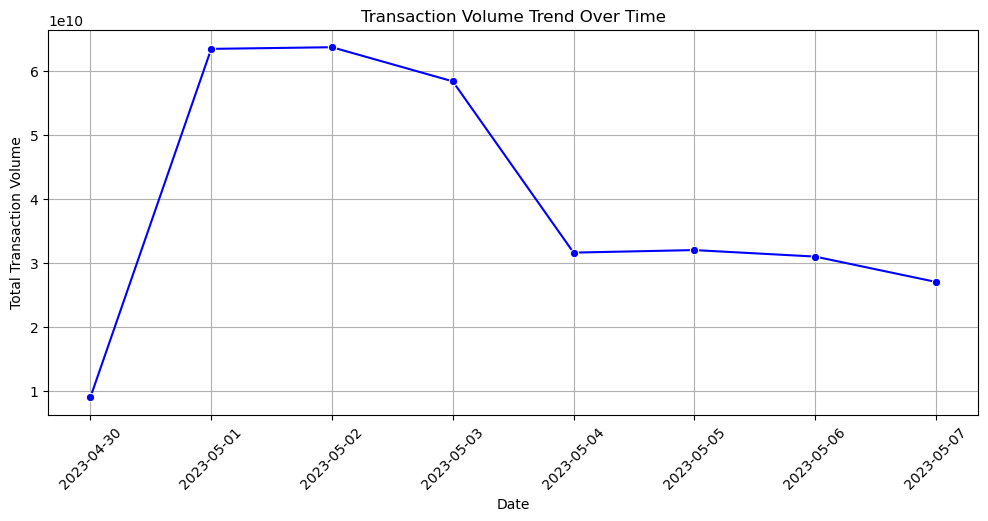

In [ ]:
# Convert timeStamp to datetime
transactions['timeStamp'] = pd.to_datetime(transactions['timeStamp'], unit='ms')

# Aggregate transactions by date to observe trends
transactions['date'] = transactions['timeStamp'].dt.date

# Visualize the trend of total transaction volume by day
plt.figure(figsize=(12, 5))
daily_trend = transactions.groupby('date')['volume'].sum()
sns.lineplot(x=daily_trend.index, y=daily_trend.values, marker='o', color='b')

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Total Transaction Volume")
plt.title("Transaction Volume Trend Over Time")
plt.grid(True)
plt.show()

Insight:
- Transactions surged on May 1st and 2nd, 2023, then showed a downward trend from May 3rd onwards.
- A significant drop occurred between May 3rd and 4th, possibly due to an anomaly or system change.
- Towards the end of the observed period (May 6th - 7th, 2023), transaction volume continued to decline slightly.

Recommendation:
- Investigate the reason behind the sharp increase on May 1st - 2nd: It could be due to a promotional campaign or an event that attracted more transactions.
- Analyze the cause of the sharp decline from May 3rd: Verify if there were system issues, transaction errors, or other factors affecting e-wallet usage.
- Strengthen transaction-stimulating campaigns over the weekends: If a decline is observed towards the end of the period, consider offering incentives to maintain stable transaction volumes.

Summary: 
- Transactions spiked at the beginning of May due to unidentified factors, followed by a sharp decline. Further investigation is needed, along with potential incentives to sustain stable transaction volumes.

<Figure size 1000x800 with 0 Axes>

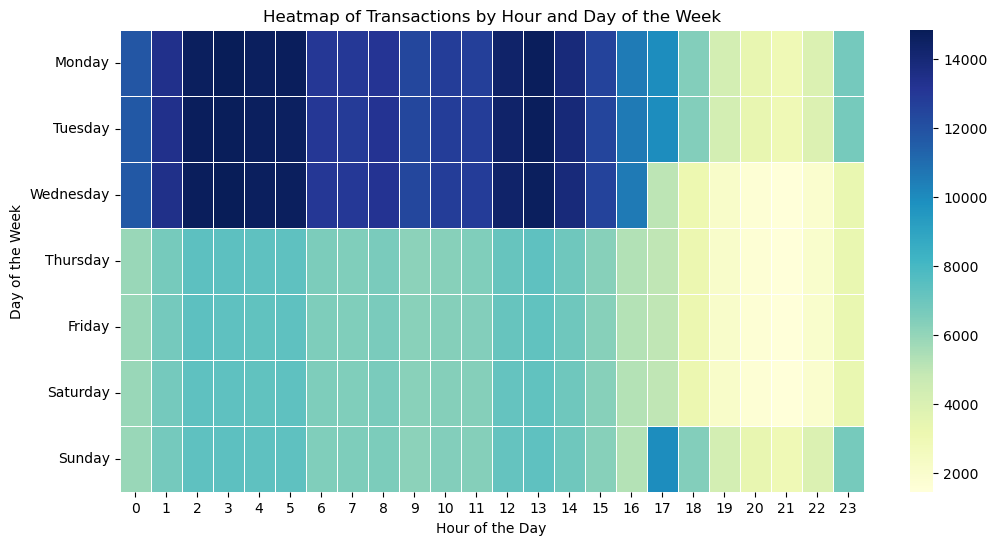

In [ ]:
# Convert problematic columns to numeric, forcing errors to NaN
transactions['sender_id'] = pd.to_numeric(transactions['sender_id'], errors='coerce')
transactions['receiver_id'] = pd.to_numeric(transactions['receiver_id'], errors='coerce')

# Heatmap of the correlation matrix without displaying numbers
plt.figure(figsize=(10, 8))
numeric_cols = transactions.select_dtypes(include=['number'])
corr_matrix = numeric_cols.corr()

# Heatmap of transaction count by hour and day of the week without displaying numbers
heatmap_data = transactions.pivot_table(index='day_of_week', columns='hour', values='transaction_id', aggfunc='count')

# Reorder days of the week
heatmap_data = heatmap_data.reindex(days_order)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5, annot=False)
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.title("Heatmap of Transactions by Hour and Day of the Week")
plt.show()

Insights:
1. Transactions peak at night and early morning (12 AM - 6 AM)
- The highest transaction volumes occur between 12 AM - 6 AM, especially on Monday to Wednesday.
- This could be due to automated system transactions or users preferring to conduct online transactions at night.
2. Sharp decline in transactions in the evening and late night
- From around 5 PM - 11 PM, transaction volume significantly drops, particularly midweek and on weekends.
- Wednesday and Thursday show a noticeable drop after 4 PM.
3. More balanced transaction activity on weekends
- Transactions remain relatively stable throughout Saturday and Sunday without any significant peaks.
- This could indicate that customers have more free time on weekends to conduct transactions.

Recommendations:
1. Optimize system performance at night
- Since transaction volume is high between 12 AM - 6 AM, ensure the system has sufficient resources to handle transactions efficiently and avoid network congestion or system errors.
- Consider scheduling system maintenance during low-transaction periods, such as 5 PM - 11 PM.
2. Increase marketing campaigns in the evening
- Since transaction volume drops from 5 PM - 11 PM, introduce promotional campaigns or discounts during this period to attract more users.
- Example: “10% transaction fee discount from 6 PM - 10 PM” or “Cashback promotions for evening transactions.”
3. Focus on weekend transaction strategies
- Since weekend transactions are more evenly distributed, businesses can introduce exclusive weekend promotions to further boost activity.
- Identify the key customer segments transacting on weekends to offer tailored promotions.

Summary:
- This heatmap highlights peak and low transaction hours, helping optimize system performance, improve marketing strategies, and enhance customer experience.